# Tarea 5

## Construccion del algoritmo UKF para el SIR

Seguimos el pseudo código.

In [2]:
import os
import UKF
import numpy as np
import pytwalk
import scipy.stats as ss
import sys
import pandas as pd
import matplotlib.pyplot as plt
""" fix the random generation seed """
np.random.seed(2025)

""" state and observation space dimension """
n = 3
m = 1

"""
load infection records
"""        
N = 550000
influenza_data = pd.read_csv("pandemic_infuenza_SF_sade.csv")
nobs=len(influenza_data)
i_time = np.linspace(0,nobs-1,nobs)
dt = i_time[1] - i_time[0]
data=influenza_data["Cases"].to_numpy()

"""
known parameters
"""
sigma = 1.0/3.0
gamma = 1.0/5.0
beta0 = 2.0*gamma
log_beta0 = np.log(beta0)

""" initialize UKF class """
ukf = UKF.UKF(n, m, nobs, dt, N)


def condCov(Pin):
        
    """ Adds nuggets of increasing magnitude to a covariance 
    matrix until the matrix is positive definite.
    """
    i = -8
    while np.any(np.linalg.eigvals(Pin + 10**i*np.eye(n)) <=0 ):
        i += 1 
        print(i)                           
    return Pin + 10**i*np.eye(n)


def is_pos_def(A):
    """ Check if square matrix is positive definite """    
    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False 


def energy(q):
        
    """ compute the prior """
    log_prior = 0.0  
    # distribucion normal para log(beta)
    log_prior += ss.norm.logpdf(q[0],loc=log_beta0,scale=0.3)
    # # distribucion gamma para E(0)
    log_prior += ss.gamma.logpdf(q[1],1,scale=10)
     # distribucion gamma para I(0)
    log_prior += ss.gamma.logpdf(q[2],1,scale=10)
    # # distribucion gamma para R(0)
    log_prior += ss.beta.logpdf(q[3],1.1,1.1,scale=N)        
    # distribucion gamma para Q
    log_prior += ss.gamma.logpdf(q[4],1,scale=N)
    log_prior += ss.gamma.logpdf(q[5],1,scale=N)
    log_prior += ss.gamma.logpdf(q[6],1,scale=N)
    # distribucion gamma para R covaranza rudo
    log_prior += ss.gamma.logpdf(q[7],1,scale=N)

    """ reset ukf variables """
    ukf.resetUKF(q)           


    """ compute the likelihood """
    log_likelihood = 0.0
    for i in range(1,nobs):

        try:        
            if not is_pos_def(ukf.P_aposteriori):
                ukf.P_aposteriori = condCov(ukf.P_aposteriori)    

            ukf.timeUpdate(i-1, q)
            ukf.measurementUpdate(data[i])
            
            if ukf.y < 0:
                return np.inf
            
            term = ss.norm.logpdf(data[i],loc=ukf.y,scale=ukf.P_y)[0][0]

        except:
            return np.inf

        log_likelihood += term
    print (-log_likelihood-log_prior)
    return -log_likelihood-log_prior
    
def support(p):
        
    """ Parameter support. Necessary for twalk
    
    Parameters
    ----------
    None.

    Returns
    -------
    X     : TYPE = Boolean
            DESCRIPTION. True if the parameters are in the support
    """
    rt = True
    rt &= (-4.0 < p[0] < 1.0)
    rt &= (0.0 < p[1] < N)
    rt &= (0.0 < p[2] < N) 
    rt &= (0.0 < p[3] < N)
    rt &= (p[1]+p[2]+p[3]<N)
    rt &= (0 < p[4] < N**2)
    rt &= (0 < p[5] < N**2)
    rt &= (0 < p[6] < N**2)
    rt &= (0 < p[7] < 10**8)
    return rt

    
def init():
        
    """ Initial parameter values. Necessary for twalk
        
    Parameters
    ----------
    None.
    
    Returns
    -------
    p       : TYPE = Array of floats
              DESCRIPTION. Sample point in the support
    
    muestrea parámetros uniformes en el soporte
    """
    p = np.zeros(8)
    p[0] = np.random.uniform(low = -4.0,high = 1.0)
    p[1] = np.random.uniform(low = 0.0,high = 100.0)
    p[2] = np.random.uniform(low = 0.0,high = 100.0)    
    p[3] = np.random.uniform(low = 0.0,high = N-200.0)
    p[4] = np.random.uniform(low = 0.0,high = 10.0)
    p[5] = np.random.uniform(low = 0.0,high = 10.0)
    p[6] = np.random.uniform(low = 0.0,high = 10.0)
    p[7] = np.random.uniform(low = 0.0,high = 10.0)
    return p  
 
""" Make sure output directory exists """
directory = "mcmc_output/"
if not os.path.exists(directory):
    os.makedirs(directory)




In [68]:
# haz una cadema de Markov con el twalk
seir = pytwalk.pytwalk(n=8,U=energy,Supp=support)
seir.Run(T=5000,x0=init(),xp0=init())
plt.figure()

pytwalk: Running the twalk with 5000 iterations .  Tue, 20 May 2025, 00:09:48.
318596.0684425713
558528.3687644323
       Finish by Tue, 20 May 2025, 00:24.
250106.18352697423


c:\Users\disom\OneDrive\CIMAT\python_code\Problemas inversos\pytwalk.py:318: RuntimeWarning: overflow encountered in exp
  A = exp(u - u_prop)


234123.825445884
162149901.37944257
115514.21375463106
177559000.79906774
85254.01218016789
76293.1932377077
428784.0731925949
82699.07242850256


c:\Users\disom\OneDrive\CIMAT\python_code\Problemas inversos\pytwalk.py:304: RuntimeWarning: overflow encountered in exp
  A = exp(up - up_prop)


39069.233605291745
210955.81012530872


c:\Users\disom\OneDrive\CIMAT\python_code\Problemas inversos\pytwalk.py:343: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) +  (self.nphi-2)*log(beta))


45319.79610584396
88565.73296982383
38439.30274753297
2449378.958419836
95758.15855795282
192783.2336064693
85641.41610327899
82434.10388024764
63888.09903465011
198880.04291249445
324573.6417261462
39612.04494084489


c:\Users\disom\OneDrive\CIMAT\python_code\Problemas inversos\pytwalk.py:360: RuntimeWarning: overflow encountered in exp
  A = exp((u - u_prop) +  (self.nphi-2)*log(beta))


7305.932936049452
24836.3910278165
29066.13492370393
18174.27686011033
27109.337785046897
26992.892249224224
6842.482393700042
108277.56890925643
18711.505490705
77685.442574596
35732.64506626311
74634.16797931089
33147.352249363874
5700.177099584942
9819.977569397011
7649.002887528761
7217.647824321817
18219.53529769667
17692.229122410678
5331.448498389412
10203.482231256083
5208.13959212436
5882.073281023428
8513.820680679932
7836.552295830736
5285.103555957883
5570.821981923389
12132.604967021716
3081.0292424815257
40393.44956777914
3001.4561342418815
16707.635564823882
4973.89067593008
2538.3320696196256
1490.6623130750504
4883.162954842009
1458.2297817520405
5035.125392851018
1898.2023281245927
6478.5906708120265
46786.49483125161
5413.1022108929255
424352.89885909506
5539.284514619188
1626.717455534759
1935.0285936951213
5441.522738266128
1956.325739900724
128818.41682317718
4653.647501405856
4504.622665095705
4741.952000359033
1887.286138304964
1429.5405414750421
3988.0229770773

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [69]:
 # guarda la cadena y la energía en un archivo
np.savetxt(directory+'/chain.dat',seir.Output[:,:-1])
np.savetxt(directory+'/probs.dat',seir.Output[:,-1])

In [70]:
chain = np.loadtxt('mcmc_output/chain.dat')
probs = np.loadtxt('mcmc_output/probs.dat')
print("chain",chain.shape)
print("prob",probs.shape)

chain (5001, 8)
prob (5001,)


(0.0, 1000.0)

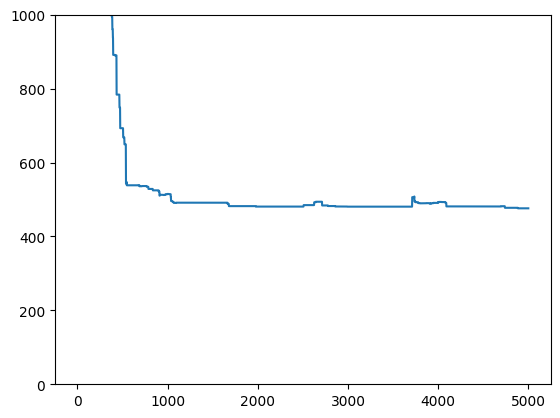

In [ ]:
plt.plot(probs)
plt.ylim(0,10000)

tamaño muestreado (4501,)
chain log beta -3.7170306804458786 0.9235918337193992
chain beta 0.24208355275091437 1.658037050445398


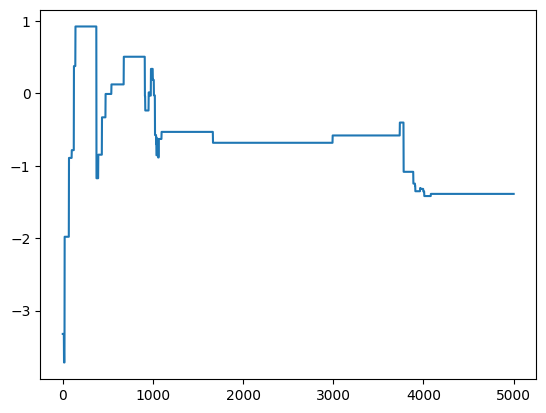

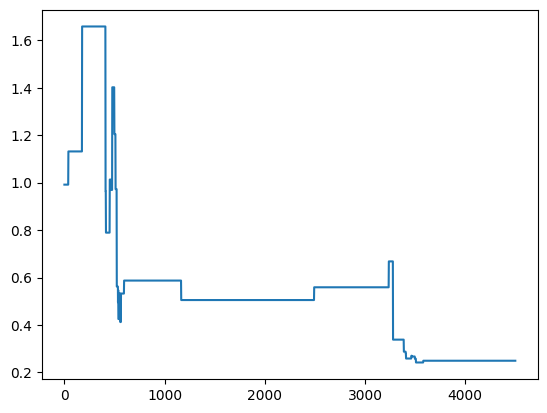

In [72]:
samples = chain[:,0]
burnin = 500
subsample = 1
beta=[]
beta.append(samples[burnin::subsample])
beta=np.exp(np.array(beta).reshape(-1))

print("tamaño muestreado", beta.shape)
print("chain log beta", np.min(samples),np.max(samples))
print("chain beta", np.min(beta), np.max(beta))
plt.plot(samples)
plt.show()
plt.plot(beta)

Text(0.5, 1.0, 'beta')

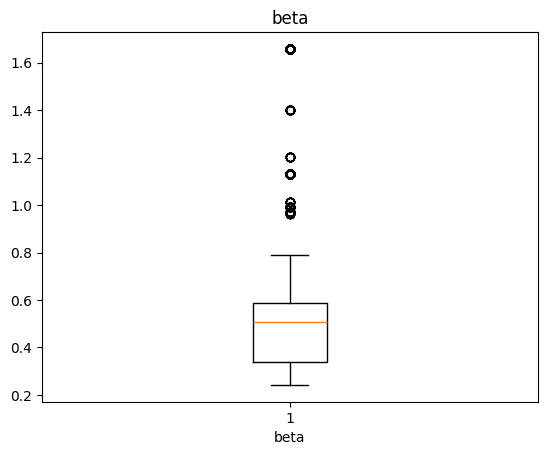

In [73]:
plt.boxplot(beta,bootstrap=500)
plt.xlabel("beta")
plt.title("beta")


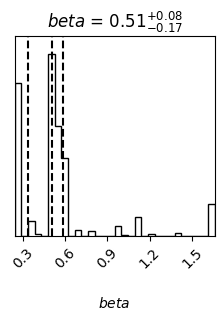

In [74]:
import corner
corner.corner(
           beta, #solo beta
            labels=[r"$beta$"],
            quantiles=[0.25, 0.5, 0.75],
            show_titles=True,
            title_kwargs={"fontsize": 12},
            bins=30,
            smooth=1.0

);

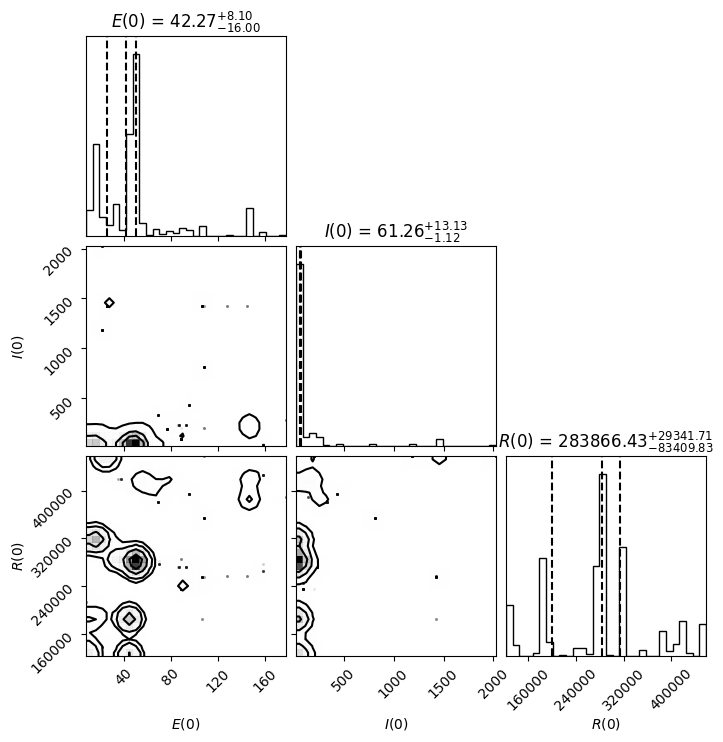

In [75]:
corner.corner(
            chain[:,1:4], #las condiciones iniciales
            labels=[r"$E(0)$", r"$I(0)$", r"$R(0)$"],
            quantiles=[0.25, 0.5, 0.75],
            show_titles=True,
            title_kwargs={"fontsize": 12},
            bins=30,
            smooth=1.0

);

chain (5001, 8)
prob (5001,)


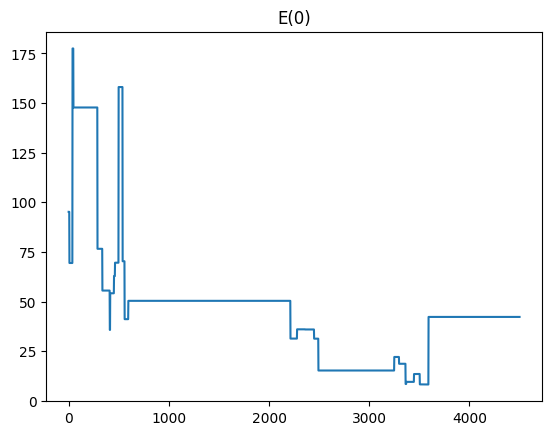

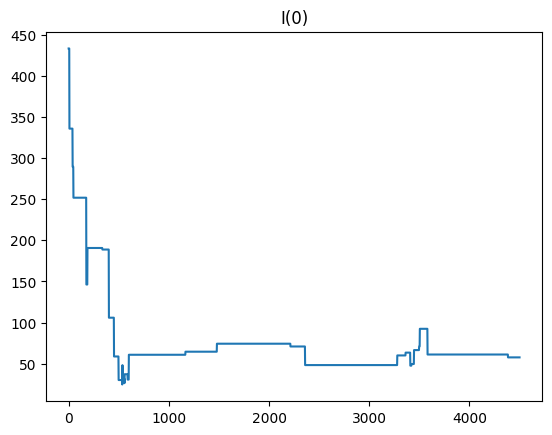

Text(0.5, 1.0, 'R(0)')

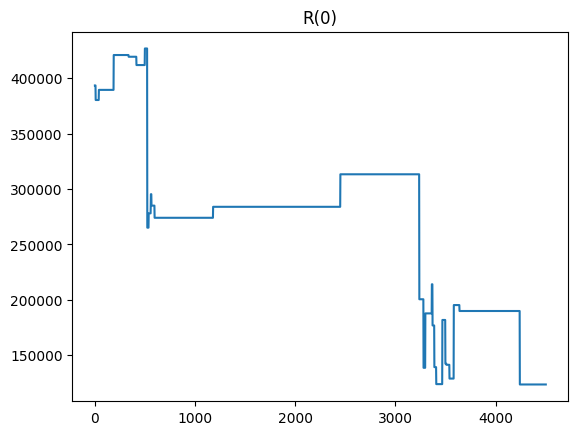

In [76]:
print("chain",chain.shape)
print("prob",probs.shape)

plt.plot(chain[burnin:,1], label="E(0)")
plt.title("E(0)")
plt.show()
plt.plot(chain[burnin:,2], label="I(0)")
plt.title("I(0)")
plt.show()
plt.plot(chain[burnin:,3], label="R(0)")
plt.title("R(0)")

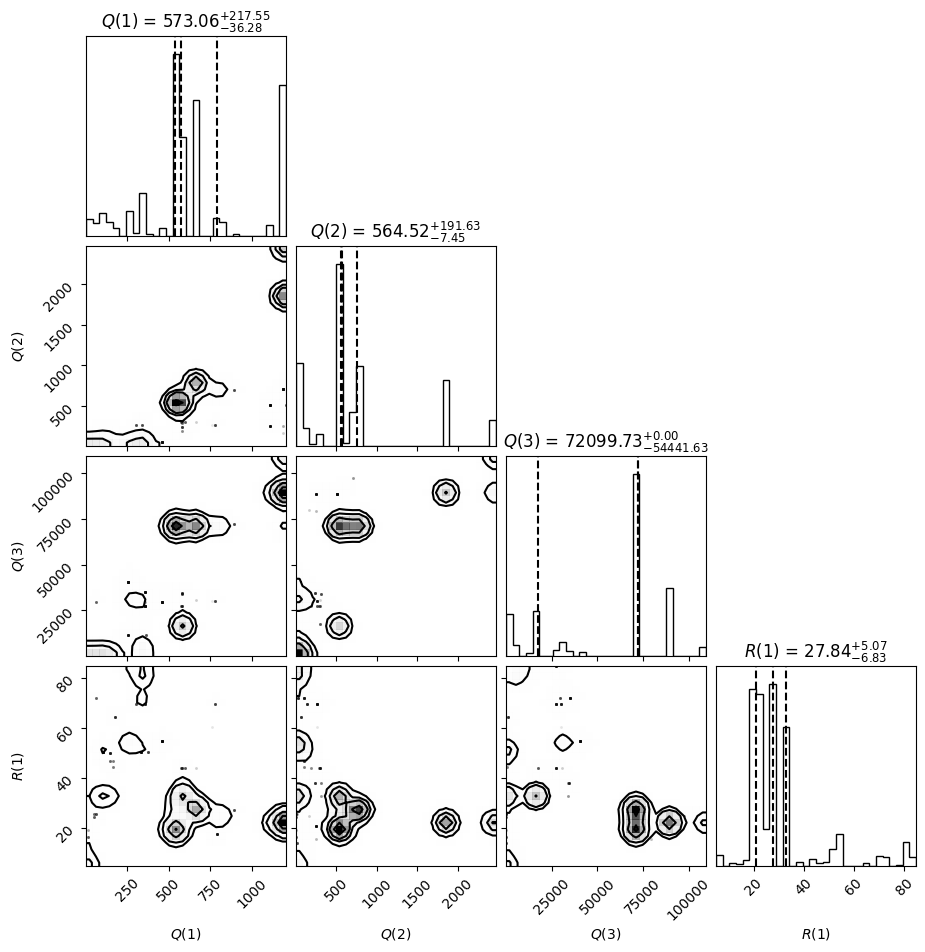

In [90]:
corner.corner(
            chain[:,4:8], #las condiciones iniciales
            labels=[r"$Q(1)$", r"$Q(2)$", r"$Q(3)$", r"$R(1)$"],
            quantiles=[0.25, 0.5, 0.75],
            show_titles=True,
            title_kwargs={"fontsize": 12},
            bins=30,
            smooth=1.0

);

In [15]:
chain = np.loadtxt('mcmc_output/chain.dat')
probs = np.loadtxt('mcmc_output/probs.dat')
print("chain",chain.shape)
print("prob",probs.shape)


chain (5001, 8)
prob (5001,)


In [16]:
import numpy as np
import scipy.stats as ss

""" fix the random generation seed """
np.random.seed(2025)

""" state and observation space dimension """
n = 3
m = 1

"""
load infection records
"""
N = 550000
influenza_data = pd.read_csv("pandemic_infuenza_SF_sade.csv")
nobs=len(influenza_data)
i_time = np.linspace(0,nobs-1,nobs)
dt = i_time[1] - i_time[0]
data=influenza_data["Cases"].to_numpy()

"""
known parameters
"""
sigma = 1.0/3.0
gamma = 1.0/5.0
beta0 = 0.51
log_beta0 = np.log(beta0)

""" initialize UKF class """
ukf = UKF.UKF(n, m, nobs, dt, N)


burnin = 1000
subsample = 150
show_n_samples = 25
n_fore = 15
    
probs = np.loadtxt('mcmc_output/probs.dat') 
chain = np.loadtxt('mcmc_output/chain.dat')
samples = chain


solns_p = np.zeros((show_n_samples,8))
solns_x = np.zeros((show_n_samples,3))     
solns_y = np.zeros((show_n_samples,nobs)) 
fore = np.zeros((show_n_samples,n_fore))       
solns_map = np.zeros(nobs)

k = 1
n_success = 0

while n_success<show_n_samples:
    try:
        solns_p[n_success,:] = samples[-(k)*subsample,:]
        ukf.resetUKF(solns_p[n_success,:])
        x_traj, y_traj, var_x_traj = [], [], []

        for i in range(1, nobs):
            ukf.timeUpdate(i - 1, solns_p[n_success,:])
            ukf.measurementUpdate(data[i])
            solns_y[n_success,i] = ukf.y
            
        solns_x[n_success,:] = ukf.x_aposteriori
        
        ukf.resetUKF(solns_p[n_success,:])

        ukf.beta_k = ss.norm.rvs(loc=ukf.beta_k,scale=0.05)
        x = ukf.state_seir(nobs-1, solns_x[n_success,:], solns_p[n_success,:])
        fore[n_success,0] = solns_p[n_success,-1]*ukf.output_seir(x[0,:])
        
        for i in range(1,n_fore):
                ukf.beta_k = ss.norm.rvs(loc=ukf.beta_k,scale=0.05)
                x = ukf.state_seir(nobs-1+i, x[:,-1], solns_p[n_success,:])
                fore[n_success,i] = solns_p[n_success,-1]*ukf.output_seir(x[0,:])             
                 
        n_success += 1
        k += 1 
    except:
            pass
            k += 1
            
solns_median = np.median(solns_y,axis=0)
solns_mean = np.mean(solns_y,axis=0)    
solns_std = np.std(solns_y,axis=0)    
solns_quant = np.quantile(solns_y,q=[0.05,0.95],axis=0) 

C:\Users\disom\AppData\Local\Temp\ipykernel_44304\1695839236.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  solns_y[n_success,i] = ukf.y


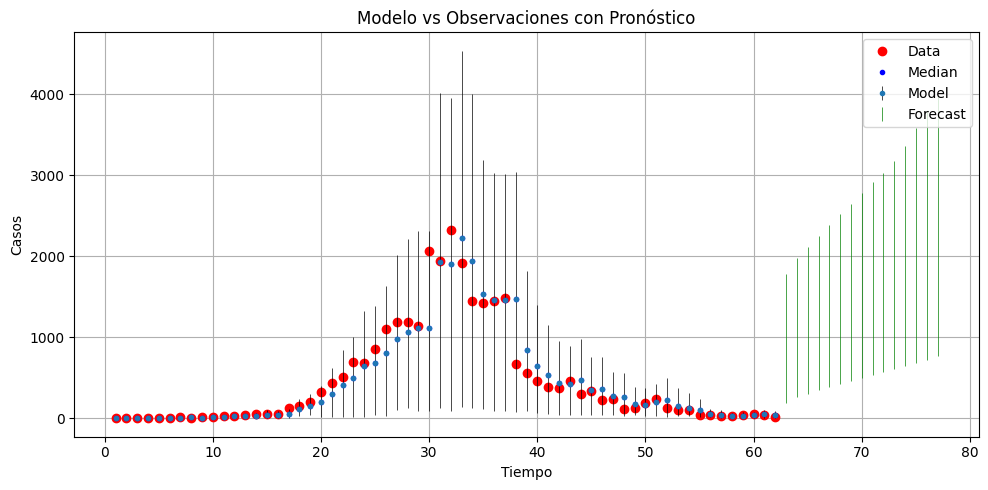

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Crear nueva figura y ejes
plt.figure(figsize=(10, 5))

# Gráfica de datos observados
plt.plot(i_time[1:], data[1:], 'ro', label='Data')

# Banda de incertidumbre del modelo
plt.errorbar(i_time[1:], solns_median[1:], yerr=solns_quant[:, 1:], fmt='.', ecolor='k', lw=0.5, label='Model')

# Mediana del modelo
plt.plot(i_time[1:], solns_median[1:], 'b.', label='Median')

# Pronóstico (forecast)
fore = np.maximum(fore, 0)
mean_fore = np.mean(fore, axis=0)
quant_fore = np.quantile(fore, q=[0.05, 0.95], axis=0)

plt.errorbar(np.linspace(nobs, nobs + n_fore - 1, n_fore),
             mean_fore,
             yerr=quant_fore,
             fmt=' ', ecolor='g', lw=0.5, label='Forecast')

# Mostrar leyenda y gráfico
plt.legend(loc=0)
plt.xlabel('Tiempo')
plt.ylabel('Casos')
plt.title('Modelo vs Observaciones con Pronóstico')
plt.grid(True)
plt.tight_layout()
plt.show()